<a href="https://colab.research.google.com/github/cemredogan-ceng/demo/blob/main/demoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings & Vektör Veritabanları Demo



## 1. Kurulum



In [9]:
!pip install -q sentence-transformers chromadb


## 2. Embedding modeli ve Chroma istemcisi



In [10]:
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings

# Çok dilli, Türkçe'yi iyi anlayan bir model
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

print("Embedding boyutu:", model.get_sentence_embedding_dimension())

# Chroma istemcisi (lokal, küçük bir vektör veritabanı gibi)
client = chromadb.Client(Settings(
    persist_directory="chroma_store",   # İstersen sabit diske kaydedilebilir
    anonymized_telemetry=False          # Telemetry kapalı
))


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding boyutu: 768


## 3. Örnek doküman seti (deprem, vektör veritabanları, ulaşım)




In [11]:
documents = [
    # Deprem / hastane / afet
    "Marmara Bölgesinde meydana gelen deprem sonrası hastanelerin acil servisleri hızla doldu.",
    "Afet yönetiminde en kritik konulardan biri, deprem sonrası hastane kapasitesinin doğru planlanmasıdır.",
    "Deprem tatbikatları, sağlık personelinin acil durumlara hazırlıklı olmasını sağlar.",

    # LLM / embedding / vektör veritabanı
    "Büyük dil modelleri, metinleri yüksek boyutlu vektörlere dönüştürerek anlam benzerliğini yakalar.",
    "Pinecone ve Weaviate, ölçeklenebilir vektör veritabanı çözümleri sunar.",
    "Chroma, yerel geliştirme ve RAG prototipleri için sık kullanılan açık kaynak bir vektör veritabanıdır.",
    "Milvus, milyarlarca vektör üzerinde hızlı benzerlik araması yapabilen dağıtık bir sistemdir.",

    # Ulaşım / şehir verisi
    "İstanbul'da toplu taşıma verileri analiz edilerek en yoğun hatlar belirlendi.",
    "Bisiklet yollarının artırılması, şehir içi ulaşımda karbon salınımını azaltabilir.",
]

ids = [f"doc_{i}" for i in range(len(documents))]

for i, doc in zip(ids, documents):
    print(i, "→", doc)


doc_0 → Marmara Bölgesinde meydana gelen deprem sonrası hastanelerin acil servisleri hızla doldu.
doc_1 → Afet yönetiminde en kritik konulardan biri, deprem sonrası hastane kapasitesinin doğru planlanmasıdır.
doc_2 → Deprem tatbikatları, sağlık personelinin acil durumlara hazırlıklı olmasını sağlar.
doc_3 → Büyük dil modelleri, metinleri yüksek boyutlu vektörlere dönüştürerek anlam benzerliğini yakalar.
doc_4 → Pinecone ve Weaviate, ölçeklenebilir vektör veritabanı çözümleri sunar.
doc_5 → Chroma, yerel geliştirme ve RAG prototipleri için sık kullanılan açık kaynak bir vektör veritabanıdır.
doc_6 → Milvus, milyarlarca vektör üzerinde hızlı benzerlik araması yapabilen dağıtık bir sistemdir.
doc_7 → İstanbul'da toplu taşıma verileri analiz edilerek en yoğun hatlar belirlendi.
doc_8 → Bisiklet yollarının artırılması, şehir içi ulaşımda karbon salınımını azaltabilir.


## 4. Dokümanları embedding vektörlerine dönüştürme



In [12]:
embeddings = model.encode(documents)
embeddings.shape


(9, 768)

## 5. Chroma koleksiyonu oluşturma ve doküman + embedding ekleme


In [13]:
collection = client.create_collection(name="demo_embeddings")

collection.add(
    documents=documents,              # Orijinal metinler
    ids=ids,                          # Doküman kimlikleri
    embeddings=embeddings.tolist()    # Numpy → liste
)

print("Toplam kayıt:", collection.count())


Toplam kayıt: 9


## 6. Semantic search fonksiyonu



In [14]:
def semantic_search(query, top_k=3):
    # 1) Sorguyu embedding'e çevir
    query_emb = model.encode([query]).tolist()

    # 2) Chroma içinde en yakın vektörleri bul
    results = collection.query(
        query_embeddings=query_emb,
        n_results=top_k
    )

    # 3) Sonuçları yazdır
    print(f"\nSorgu: {query}")
    print("-" * 80)
    for doc, dist, _id in zip(results["documents"][0],
                              results["distances"][0],
                              results["ids"][0]):
        print("ID:", _id)
        print("Distance:", round(dist, 4))
        print("Document:", doc)
        print("-" * 80)


## 7. Örnek Sorgu 1 – Deprem & hastane kapasitesi


In [15]:
semantic_search("depremden sonra hastane kapasitesini planlamak istiyorum", top_k=3)



Sorgu: depremden sonra hastane kapasitesini planlamak istiyorum
--------------------------------------------------------------------------------
ID: doc_1
Distance: 2.0555
Document: Afet yönetiminde en kritik konulardan biri, deprem sonrası hastane kapasitesinin doğru planlanmasıdır.
--------------------------------------------------------------------------------
ID: doc_2
Distance: 5.0241
Document: Deprem tatbikatları, sağlık personelinin acil durumlara hazırlıklı olmasını sağlar.
--------------------------------------------------------------------------------
ID: doc_0
Distance: 5.6798
Document: Marmara Bölgesinde meydana gelen deprem sonrası hastanelerin acil servisleri hızla doldu.
--------------------------------------------------------------------------------


## 8. Örnek Sorgu 2 – Vektör veritabanları



In [16]:
semantic_search("hangi vektör veritabanları büyük ölçekli aramalar için uygun", top_k=3)



Sorgu: hangi vektör veritabanları büyük ölçekli aramalar için uygun
--------------------------------------------------------------------------------
ID: doc_6
Distance: 5.7284
Document: Milvus, milyarlarca vektör üzerinde hızlı benzerlik araması yapabilen dağıtık bir sistemdir.
--------------------------------------------------------------------------------
ID: doc_4
Distance: 5.9495
Document: Pinecone ve Weaviate, ölçeklenebilir vektör veritabanı çözümleri sunar.
--------------------------------------------------------------------------------
ID: doc_3
Distance: 6.3654
Document: Büyük dil modelleri, metinleri yüksek boyutlu vektörlere dönüştürerek anlam benzerliğini yakalar.
--------------------------------------------------------------------------------


## 9. Örnek Sorgu 3 – Ulaşım ve şehir içi veri analizi


In [21]:
semantic_search("şehir içi ulaşım verilerini analiz etmek istiyorum", top_k=2)



Sorgu: şehir içi ulaşım verilerini analiz etmek istiyorum
--------------------------------------------------------------------------------
ID: doc_7
Distance: 4.7861
Document: İstanbul'da toplu taşıma verileri analiz edilerek en yoğun hatlar belirlendi.
--------------------------------------------------------------------------------
ID: doc_8
Distance: 7.3996
Document: Bisiklet yollarının artırılması, şehir içi ulaşımda karbon salınımını azaltabilir.
--------------------------------------------------------------------------------


## 10. Ek 1 – Embedding'leri 2 boyuta indirip görselleştirme (PCA)


Amaç:
- 768 boyutlu embedding vektörlerini **PCA ile 2 boyuta indirgemek**,
- Deprem, vektör veritabanı ve ulaşım dokümanlarının, 2D uzayda birbirine nasıl gruplanıp gruplanmadığını görmek.

Gerçekte embedding'ler çok boyutlu uzayda yaşıyor; burada sadece bunun sezgisel bir görselini elde etmiş oluyoruz.


In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Doküman gruplarını etiketleyelim
labels = [
    "Deprem/Hastane",
    "Deprem/Hastane",
    "Deprem/Hastane",
    "Vektör DB",
    "Vektör DB",
    "Vektör DB",
    "Vektör DB",
    "Ulaşım",
    "Ulaşım",
]

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

embeddings_2d.shape


(9, 2)

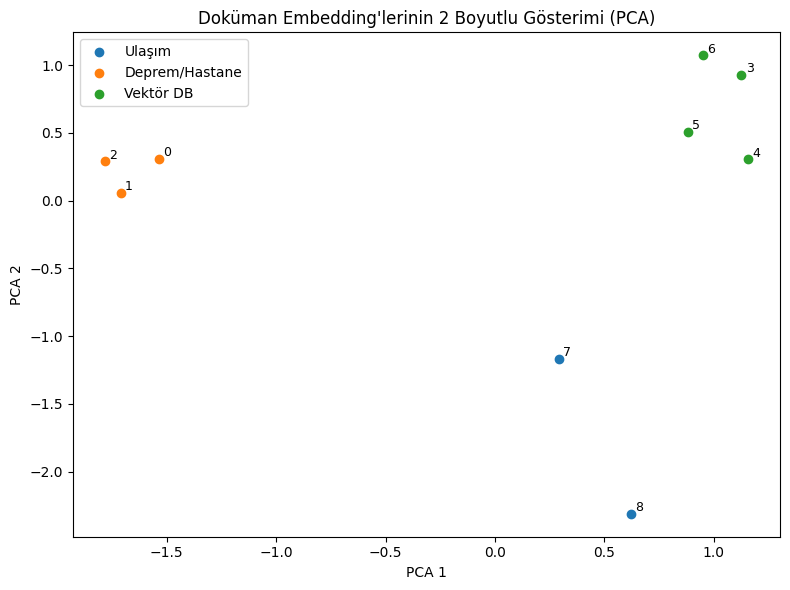

In [19]:
# 2D scatter plot
plt.figure(figsize=(8, 6))

unique_labels = list(set(labels))

for lab in unique_labels:
    mask = [l == lab for l in labels]
    points = embeddings_2d[mask]
    plt.scatter(points[:, 0], points[:, 1], label=lab)

# Noktaların yanına ID yazalım
for i, (x, y) in enumerate(embeddings_2d):
    plt.text(x + 0.02, y + 0.02, f"{i}", fontsize=9)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Doküman Embedding'lerinin 2 Boyutlu Gösterimi (PCA)")
plt.legend()
plt.tight_layout()
plt.show()


## 11. Ek 2 – Mini RAG demosu (Retriever + Bağlam)

RAG (Retrieval-Augmented Generation) fikri:

1. Önce **retrieval** yapılır:
   - Soru → embedding
   - Vektör veritabanından en alakalı dokümanlar alınır.
2. Sonra bu dokümanlar, büyük dil modeline **bağlam (context)** olarak verilir.
3. LLM, hem soruya hem de bu bağlama bakarak cevap üretir.

Burada:

- Bir RAG sisteminin **retrieval** kısmını zaten yaptık (semantic_search).
- Şimdi benzer mantıkla bağlamı birleştirip,
- "Bu bağlamı bir LLM'e verseydik nasıl bir cevap beklerdik?" sorusuna yaklaşacağız.


In [20]:
def build_context(question, top_k=3):
    """Soruya göre en alakalı dokümanları bulup tek bir metinde birleştirir."""
    query_emb = model.encode([question]).tolist()
    results = collection.query(
        query_embeddings=query_emb,
        n_results=top_k
    )
    docs = results["documents"][0]
    context = "\n\n".join(docs)
    return context, docs

question = "Deprem sonrası hastane kapasitesi nasıl planlanmalı?"
context, ctx_docs = build_context(question, top_k=3)

print("Soru:")
print(question)
print("\n--- Geri getirilen bağlam (context) ---\n")
print(context)


Soru:
Deprem sonrası hastane kapasitesi nasıl planlanmalı?

--- Geri getirilen bağlam (context) ---

Afet yönetiminde en kritik konulardan biri, deprem sonrası hastane kapasitesinin doğru planlanmasıdır.

Deprem tatbikatları, sağlık personelinin acil durumlara hazırlıklı olmasını sağlar.

Marmara Bölgesinde meydana gelen deprem sonrası hastanelerin acil servisleri hızla doldu.


## 10. Özet

Bu demoda:

- Metinleri vektörlere dönüştürmek için **embedding modeli** kullandık.
- Bu vektörleri **Chroma** içinde saklayarak küçük bir **vektör veritabanı** oluşturduk.
- Farklı sorgularla **semantic search (anlama dayalı arama)** yaptık:
  - Deprem & hastane kapasitesi
  - Vektör veritabanları (Pinecone, Weaviate, Milvus, Chroma)
  - Ulaşım & şehir verisi

- Embedding’leri PCA ile görselleştirdik

- Mini bir RAG akışı gösterdik

Gerçek hayatta:
- Bu demo ölçeği Chroma ile güzel,
- Büyük ölçekli üretim sistemlerinde ise Pinecone, Weaviate veya Milvus gibi sistemler kullanılıyor.
